In [1]:
import pdb
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
import pdb
import time

%matplotlib inline

In [2]:
'''Data loading'''
f_names_national = [
    '2012 Conso Prod.csv',
    '2013 Conso Prod.csv',
    '2014 Conso Prod.csv',
    '2015 Conso Prod.csv'
]

datas = []
data_news = []
for f_name in f_names_national:
#     print(f_name)
    data = pd.read_csv('data/'+ f_name, delimiter='\t', encoding = "ISO-8859-1")
    pd.set_option('max_columns', 100)
    headers = list(data)
    data = data[data.Consommation.notnull()]
    data = data[data.Date.notnull()]
    data['timestamp'] = [str(d) + ' ' + str(t) for d, t in zip(data['Date'].values, data['Heures'].values)]
    data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M')
    datas.append(data)

data_final = pd.concat(datas).reset_index()


/home/benlet/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/benlet/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Sorting values : le premier élement du data set est le plus récent : 
# y(t), y(t-1) etc... 
data_final = data_final.sort_values(by=['Date','Heures'], ascending=[False,False])

'''tau : paramètre de périodicité'''
tau = 10 # 48 : on considère une corrélation de 24h. On pourrait prendre tau = 1 an 
            # afin de correler les données avec les données de l'année passée


data_mean = np.mean(data_final['Consommation'].values)
data_maxmin = np.max(data_final['Consommation'].values) - np.min(data_final['Consommation'].values)

def data_labels(dataframe=data_final, field='Consommation', tau = tau):
    X = dataframe[field].values
    
    ''' Normalization '''
    X = (X - data_mean) / data_maxmin
    ''' Rolling vector X'''
    X_ = np.stack([np.roll(X,i) for i in range(tau+1)], axis=1)

    labels = X_[:,:1]
    data = X_[:,1:]
    return data, labels


In [4]:
# Creating the training set and the crossvalidation set.
# two years of training, 1 year for cv 
n_samples = data_final.Consommation.values.shape[0]
data_train, labels_train = data_labels(dataframe = data_final[(data_final['Date'] <= '2015-01-31') & (data_final['Date'] > '2014-12-31')])
data_test, labels_test = data_labels(dataframe = data_final[(data_final['Date'] > '2015-01-31') & (data_final['Date'] <= '2016-01-01')])

# ANN - Simple MLP

In [5]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [6]:
%%time
# create and fit Multilayer Perceptron model
from keras import optimizers

model = Sequential()
model.add(Dense(15, input_dim=tau, activation='relu'))
model.add(Dense(1))
# optimizer = optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(data_train, labels_train, nb_epoch=20, batch_size=10, verbose=2)

Epoch 1/20
0s - loss: 0.0095
Epoch 2/20
0s - loss: 0.0020
Epoch 3/20
0s - loss: 0.0013
Epoch 4/20
0s - loss: 9.0517e-04
Epoch 5/20
0s - loss: 7.2106e-04
Epoch 6/20
0s - loss: 5.8873e-04
Epoch 7/20
0s - loss: 4.7790e-04
Epoch 8/20
0s - loss: 4.0559e-04
Epoch 9/20
0s - loss: 3.7872e-04
Epoch 10/20
0s - loss: 3.4350e-04
Epoch 11/20
0s - loss: 3.2451e-04
Epoch 12/20
0s - loss: 3.2447e-04
Epoch 13/20
0s - loss: 2.9842e-04
Epoch 14/20
0s - loss: 2.7896e-04
Epoch 15/20
0s - loss: 2.8764e-04
Epoch 16/20
0s - loss: 2.6778e-04
Epoch 17/20
0s - loss: 2.6490e-04
Epoch 18/20
0s - loss: 2.6062e-04
Epoch 19/20
0s - loss: 2.5999e-04
Epoch 20/20
0s - loss: 2.6229e-04
CPU times: user 5.38 s, sys: 625 ms, total: 6 s
Wall time: 4.89 s


In [7]:
%%time
# Estimate model performance
trainScore = model.evaluate(data_train, labels_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(data_test, labels_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))
fitness = 1 / (1+ testScore)
print('Fitness: %.7f  ' % (fitness))

Train Score: 0.00 MSE (0.02 RMSE)
Test Score: 0.00 MSE (0.05 RMSE)
Fitness: 0.9978552  
CPU times: user 484 ms, sys: 15.6 ms, total: 500 ms
Wall time: 446 ms


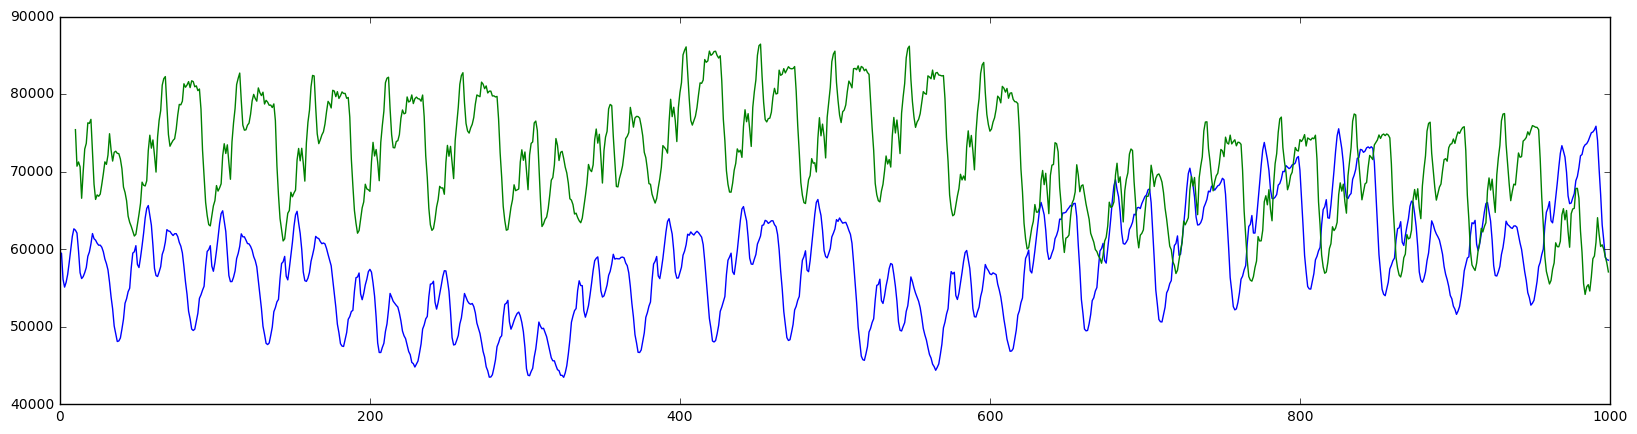

In [8]:
# generate predictions for training
trainPredict = model.predict(data_train) * data_maxmin + data_mean
testPredict = model.predict(data_test) * data_maxmin + data_mean
n_samples = data_train.shape[0] + data_test.shape[0]
# shift train predictions for plotting
trainPredictPlot = np.zeros((n_samples,1))
trainPredictPlot[:, :] = np.nan
trainPredictPlot[tau:len(trainPredict), :] = trainPredict[:-tau,:]
# shift test predictions for plotting
testPredictPlot = np.zeros((n_samples,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(tau)+1:(n_samples), :] = testPredict[:-tau-1,:]
# plot baseline and predictions
sl= slice(0,1000)
plt.figure(figsize=(20,5))
plt.plot(data_final[data_final['Date'] > '2014-12-31']['Consommation'].values[sl])
plt.plot(trainPredictPlot[sl])
plt.plot(testPredictPlot[sl])
plt.show()

# Genetic Algorithm

In [9]:
population_size = 4
max_generations = 2
crossover_weights = 0.9
bestfit = 1e-4 # not used
minF = 0.99 # not used

In [10]:
params = {'time_lags' : 48, 'hidden_units' : 20, 'training_algo' : "adam" }
params_minmax = {'time_lags' : [1, 10], 'hidden_units' : [1, 30], 'training_algo' : "adam" }

In [11]:

class Individual(object):
    """An individual in a population."""

    def __init__(self, vector):
        """Initialize with an encoded vector and fitness function."""
        self.phenotype = self.validate_vector(vector)
        print(self.phenotype)
        self.fitness = self.calculate_fitness()

    def validate_vector(self, vector, params_minmax= params_minmax):
        """Make sure all elements are between minmax"""
        validated_vector = {}
        for key in vector:
            if (vector[key] <= params_minmax[key][1]) & (vector[key] >= params_minmax[key][0]):
                validated_vector[key] = vector[key]
            else :
                validated_vector[key] = params_minmax[key][1]
                
        return validated_vector

    def calculate_fitness(self):
        """Get the individual's fitness. EXPENSIVE."""
        # run network 
        NN = NeuralNetwork(phenotype = self.phenotype)
        NN.fitness()
        
        return NN.fitness

In [12]:

class NeuralNetwork(object):
    
    def __init__(self, phenotype):
        self.phenotype = phenotype
        self.individual_trained = 0
        self.lags = int(phenotype['time_lags'])
    # create and fit Multilayer Perceptron model
    
    def train(self, X, Y) :
        pass
    
    def fitness(self) :
        X_train, Y_train = data_labels(dataframe = data_final[(data_final['Date'] <= '2015-01-31') & (data_final['Date'] > '2014-12-31')], tau=self.lags)
        X_test, Y_test = data_labels(dataframe = data_final[(data_final['Date'] > '2015-01-31') & (data_final['Date'] <= '2016-01-01')], tau=self.lags)
  
        model = Sequential()
        model.add(Dense(self.phenotype['hidden_units'], #parameter of each individual
                        input_dim=self.phenotype['time_lags'], #parameter of each individual
                        activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X_train, Y_train, nb_epoch=20, batch_size=30, verbose=2)

#             self.train(X= X_train, Y= Y_train)
        self.trainPredict = model.predict(X_train)
        self.testPredict = model.predict(X_test)
        self.trainScore = model.evaluate(X_train, Y_train, verbose=0)
        self.testScore = model.evaluate(X_test, Y_test, verbose=0)
        self.fitness = 1 / (1 + self.testScore)
        print("Fitness = %.2e" %(self.fitness))

In [13]:
# Initialize the population at t=0 - build list of Individual objects
class Population(object):
    
    def __init__(self, params, params_minmax):
        self.params = params
        self.params_minmax = params_minmax
    
        self.initial_population = []

        for individual in range(0, population_size):

            individual_dico = {}
            individual_dico.clear()

            individual_dico['hidden_units'] = np.random.randint(
                self.params_minmax['hidden_units'][0], self.params_minmax['hidden_units'][1])
            individual_dico['time_lags'] = np.random.randint(
                self.params_minmax['time_lags'][0], self.params_minmax['time_lags'][1])
#             print(individual_dico)
            new_individual = Individual(individual_dico)
            self.initial_population.append(new_individual)
            self.population = self.initial_population
        print("Population of %d individuals initialized" % (len(self.population)))
        
    def remove_worst_individual(self):
        all_fitness = [self.population[i].fitness for i in range(len(self.population))]

        del self.population[np.argmin(all_fitness)]

    def add_individual(self, popu):
        if len(popu) ==1 :
            self.population.append(popu[0])
        else :
            all_fitness = [popu[i].fitness for i in range(len(popu))]
            self.population.append(popu[np.argmax(all_fitness)])
            
    def global_fitness(self):
        return np.mean([self.population[i].fitness for i in range(len(self.population))])
        

In [14]:
class Evolution(object):
    
    def __init__(self, population_initiale, params_minmax= params_minmax, w=crossover_weights):
        self.population = population_initiale
        self.popu_size = len(population_initiale)
        self.params_minmax = params_minmax
        self.w = w
        
    
    def crossover_mutation(self):
        '''Function to perform cross-over and mutation'''
        
        # random selection of two parents 
        i, j = np.random.choice(np.arange(0,self.popu_size), 2, replace = False) 
        papa = self.population[i].phenotype
        self.nb_params = len(papa)
        maman = self.population[j].phenotype
        
        '''Crossover'''
        C = np.zeros((4, len(papa)))
        M = np.zeros(C.shape)
        for k, key in enumerate(papa):
            c1 = (papa[key] + maman[key])/2
            c2 = params_minmax[key][1] * (1-self.w) + max(papa[key], maman[key]) *self.w
            c3 = params_minmax[key][0] * (1-self.w) + min(papa[key], maman[key]) *self.w
            c4 = (params_minmax[key][1]- params_minmax[key][0]) * (1-self.w) +\
                (papa[key] + maman[key])/2
            
            C[0,k] = c1 
            C[1,k] = c2
            C[2,k] = c3
            C[3,k] = c4
            
            for l in range(4) :
                M[l,k] = np.random.randint(params_minmax[key][0]- C[l,k], \
                                    params_minmax[key][1]+ C[l,k])
        
        '''Mutation'''
        # 1st mutation 
        sig = np.zeros(len(papa))
        sig[np.random.choice(len(papa))]=1

        for l in range(4):
            self.Mutation1 = C[l,:] + np.multiply(M[l,:],sig)

        # 2nd mutation 
        sig = np.zeros(len(papa))
        sig[np.random.choice(len(papa),len(papa),replace=True)]=1

        for l in range(4):
            self.Mutation2 = C[l,:] + np.multiply(M[l,:],sig)

        # 3rd mutation 
        sig = np.ones(len(papa))

        for l in range(4):
            self.Mutation3 = C[l,:] + np.multiply(M[l,:],sig)
            
        self.Mutation = []
        self.Mutation = [self.Mutation1, self.Mutation2, self.Mutation3]
        
        '''return dictionnary of mutated chromosomes'''
        return self.convert_to_dict(np.rint(C)),\
                self.convert_to_dict(np.rint(self.Mutation)) \


    def convert_to_dict(self, vector):
        '''conversion of a vector to a phenotype dictionary'''
        n = vector.shape[0]
        key = [ 'time_lags', 'hidden_units',]
        return [dict(zip(key, np.atleast_2d(vector)[l,:]))  for l in range(np.atleast_2d(vector).shape[0])]

        

In [15]:
%%time 

'''Modified GA'''
num_generations = 0 
global_fitness=[]
global_population = []

'''initializing population'''
print("-"*78)
print(25*" "+"POPULATION INITIALIZATION ")
print("-"*78)

Population_ = Population(params,params_minmax)
global_population.append([Population_.initial_population[i].phenotype for i in range(len(Population_.population))])


'''Evaluate fitness for the initial population'''
global_fitness.append(Population_.global_fitness())

while num_generations < max_generations :
    
    num_generations +=1 
    
    Evo = Evolution(Population_.population)
    Evo.crossover_mutation()
    
    print("-"*78)
    print(25*" "+"CROSS-OVER %d" %(num_generations))
    print("-"*78)
    
    '''removing worst individual and add best crossover individual'''
    cross_over_popu = [Individual(Evo.crossover_mutation()[0][i]) \
                       for i in range(len(Evo.crossover_mutation()[0]))]

    Population_.remove_worst_individual()
    Population_.add_individual(popu = cross_over_popu)
    
    
    print("-"*78)
    print(25*" "+"MUTATION %d" %(num_generations))
    print("-"*78)
    
    '''mutation acceptance'''
    p_mutation = 0.1
    mutation_population = [Individual(Evo.crossover_mutation()[1][i]) for i in range(len(Evo.crossover_mutation()[1]))]

    for l in range(3):
        if np.random.rand() < p_mutation:
            print("Mutated Chromosome v1 %d " %l)
            Population_.remove_worst_individual()
            Population_.add_individual(popu = [mutation_population[l]])
        else:
            popu_fitness = [Population_.population[i].fitness for i in range(len(Population_.population))]
            if mutation_population[l].fitness > np.argmin(popu_fitness):
                print("Mutated Chromosome v2 %d " %l)
                Population_.remove_worst_individual()
                Population_.add_individual(popu = [mutation_population[l]])

        
    '''Evaluate fitness for the population'''
    global_fitness.append(Population_.global_fitness())
    global_population.append([Population_.population[i].phenotype for i in range(len(Population_.population))])
    

------------------------------------------------------------------------------
                         POPULATION INITIALIZATION 
------------------------------------------------------------------------------
{'hidden_units': 23, 'time_lags': 8}
Epoch 1/20
0s - loss: 0.0028
Epoch 2/20
0s - loss: 0.0019
Epoch 3/20
0s - loss: 0.0012
Epoch 4/20
0s - loss: 8.2728e-04
Epoch 5/20
0s - loss: 6.9500e-04
Epoch 6/20
0s - loss: 6.0542e-04
Epoch 7/20
0s - loss: 5.4719e-04
Epoch 8/20
0s - loss: 5.2003e-04
Epoch 9/20
0s - loss: 4.8389e-04
Epoch 10/20
0s - loss: 4.3802e-04
Epoch 11/20
0s - loss: 4.2271e-04
Epoch 12/20
0s - loss: 3.9947e-04
Epoch 13/20
0s - loss: 4.0204e-04
Epoch 14/20
0s - loss: 3.6520e-04
Epoch 15/20
0s - loss: 3.5723e-04
Epoch 16/20
0s - loss: 3.7365e-04
Epoch 17/20
0s - loss: 3.3912e-04
Epoch 18/20
0s - loss: 3.2782e-04
Epoch 19/20
0s - loss: 3.1940e-04
Epoch 20/20
0s - loss: 3.0754e-04
Fitness = 9.93e-01
{'hidden_units': 29, 'time_lags': 4}
Epoch 1/20
0s - loss: 0.0475
Epoch 2/2

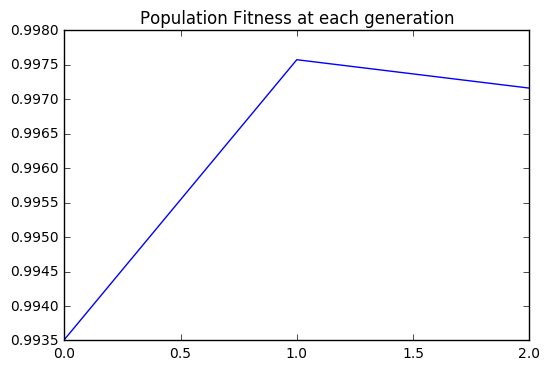

In [16]:
plt.plot(global_fitness)
plt.title("Population Fitness at each generation")
plt.savefig("Population_fitness.png")

In [68]:
initial_popu = global_population[0]
final_population = global_population[-1]

In [71]:
df_ini = pd.DataFrame(initial_popu)
df_final = pd.DataFrame(final_population)

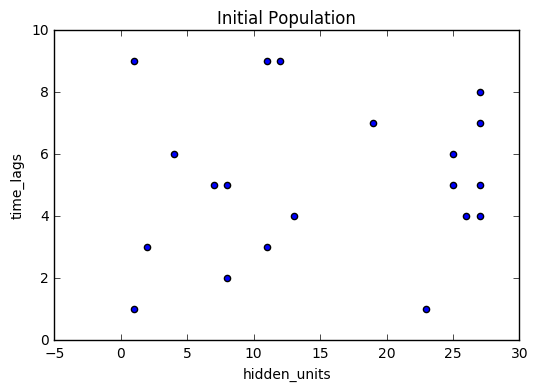

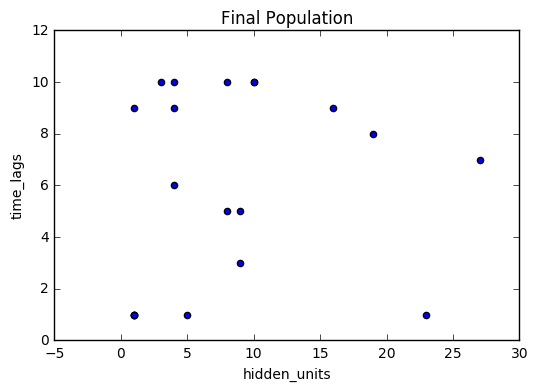

In [80]:
'''Plots of parameters for each individuals for initial population and finalpopulation'''
df_ini.plot(kind='scatter', x='hidden_units', y='time_lags', title='Initial Population')
plt.savefig("population_initiale.png")
df_final.plot(kind='scatter', x='hidden_units', y='time_lags',title='Final Population')
plt.savefig("population_finale.png")